## Creates reports for all users

In [9]:
%matplotlib inline


from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

import datetime

from pylab import figure, axes, pie, title, show

import math
#import matplotlib.pyplot as plt
#import matplotlib.mlab as mlab
#from matplotlib import gridspec
import numpy as np
import pandas as pd
import networkx as nx

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)

### Set interval 

In [2]:
cdt = datetime.datetime.utcnow() #cdt = datetime.datetime(2017,1,21,9,0,0)

GT = (cdt - datetime.timedelta(hours=7*24)).strftime("%Y%m%dT%H%m%S+0000")
LT = cdt.strftime("%Y%m%dT%H%m%S+0000")
print('between: ', GT, ' and ', LT)

between:  20170214T170229+0000  and  20170221T170229+0000


### find indices to query

In [3]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = [x for x in indices if x != '']
indices = [x.strip() for x in indices]

ind=[]
for n in range(0,9):
    pday  = cdt - datetime.timedelta(days=n)
    i='jobs_archive_%d-%02d-%02d' % (pday.year, pday.month, pday.day)
    if i in indices: ind.append(i)

print(ind)

['jobs_archive_2017-02-21', 'jobs_archive_2017-02-20', 'jobs_archive_2017-02-19', 'jobs_archive_2017-02-18', 'jobs_archive_2017-02-17', 'jobs_archive_2017-02-16', 'jobs_archive_2017-02-15', 'jobs_archive_2017-02-14', 'jobs_archive_2017-02-13']


## Get the data from Elasticsearch, and store the record based on its type

In [4]:
my_query = {
  'size': 0,
  'query':{
    'bool':{
      'must' : [
        {'term':{'prodsourcelabel':'user'}}
      ]
    }
  },
  "aggs" : {
    "user" : {
      "terms" : { "field" : "produserid", "size": 3 },
      "aggs" : {
        "jobstatus" : {
          "terms" : {"field" : "jobstatus", "size": 5},
          "aggs" : {
            "walltime" : { "sum" :{"field" : "wall_time"} },
            "cputime" : { "sum" :{"field" : "cpuconsumptiontime"} }
          }
        },
        "priority":{"avg" :{"field" : "currentpriority"}}
      }
    },
    "tot_walltime" : { "sum" :{"field" : "wall_time"} },
    "tot_cputime" : { "sum" :{"field" : "cpuconsumptiontime"} },
    "tot_priority": {"avg" :{"field" : "currentpriority"} }
  }
}

#execute query
res = es.search(index=ind, body=my_query, request_timeout=120)
res=res['aggregations']
print(res)



{'tot_cputime': {'value': 12148641713.0}, 'tot_walltime': {'value': 16867633642.0}, 'user': {'sum_other_doc_count': 6084780, 'doc_count_error_upper_bound': 117918, 'buckets': [{'priority': {'value': 2781.508140045624}, 'doc_count': 423462, 'jobstatus': {'sum_other_doc_count': 0, 'doc_count_error_upper_bound': 0, 'buckets': [{'doc_count': 405967, 'walltime': {'value': 269263702.0}, 'cputime': {'value': 159116145.0}, 'key': 'finished'}, {'doc_count': 11699, 'walltime': {'value': 11967246.0}, 'cputime': {'value': 946766.0}, 'key': 'failed'}, {'doc_count': 5796, 'walltime': {'value': 13696969.0}, 'cputime': {'value': 918894.0}, 'key': 'cancelled'}]}, 'key': '/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=gangarbt/CN=601592/CN=Robot: Ganga Robot/CN=proxy'}, {'priority': {'value': -13201.069383983378}, 'doc_count': 318157, 'jobstatus': {'sum_other_doc_count': 0, 'doc_count_error_upper_bound': 0, 'buckets': [{'doc_count': 163809, 'walltime': {'value': 173594802.0}, 'cputime': {'value': 126960754

### usefull functions

In [5]:
def parseUname(FN):
    #print(FN)
    unW=FN.lstrip('/').replace('/CN=proxy','').split('/')
    #extract all CN= that are not a number
    CNs=[]
    for i in unW:
        if i[:3]=='CN=': 
            i=i[3:]
            if not i.isdigit(): 
                CNs.append(i)
    if len(CNs)==1:
        return CNs[0]
    for un in CNs:
        if un.count(' ')==0:
            return un

### creating plots

gangarbt 423462 2781.508140045624
[{'doc_count': 405967, 'walltime': {'value': 269263702.0}, 'cputime': {'value': 159116145.0}, 'key': 'finished'}, {'doc_count': 11699, 'walltime': {'value': 11967246.0}, 'cputime': {'value': 946766.0}, 'key': 'failed'}, {'doc_count': 5796, 'walltime': {'value': 13696969.0}, 'cputime': {'value': 918894.0}, 'key': 'cancelled'}]
{'doc_count': 405967, 'walltime': {'value': 269263702.0}, 'cputime': {'value': 159116145.0}, 'key': 'finished'}
{'doc_count': 11699, 'walltime': {'value': 11967246.0}, 'cputime': {'value': 946766.0}, 'key': 'failed'}
{'doc_count': 5796, 'walltime': {'value': 13696969.0}, 'cputime': {'value': 918894.0}, 'key': 'cancelled'}


NameError: name 'title' is not defined

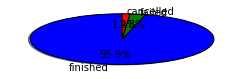

In [7]:
tot_walltime=res['tot_walltime']['value']
tot_cputime=res['tot_cputime']['value']
tot_priority=res['tot_priority']['value']

users=res['user']['buckets']
for u in users:
    uname = parseUname(u['key'])
    ujobs=u['doc_count']
    upriority=u['priority']['value']
    print (uname, ujobs, upriority)
    jobstatus=u['jobstatus']['buckets']
    print(jobstatus)
    #print(u)
    jskey=[]
    jscount=[]
    jscpu=[]
    jswall=[]
    for js in jobstatus:
        print(js)
        jskey.append(js['key'])
        jscount.append(js['doc_count'])
        jscpu.append(js['cputime']['value'])
        jswall.append(js['walltime']['value'])
        
    plt.figure(figsize=[14, 15])
    gs = gridspec.GridSpec(2, 3, height_ratios=[1,1,1,1,1,1,1,1,1,1,1,1])
    
    ax0 = plt.subplot(gs[0])
    ax0.pie(jscount, labels=jskey, autopct='%1.1f%%', shadow=True, startangle=90)
    title('number of jobs', bbox={'facecolor': '0.8', 'pad': 5})
    ax0.axis('equal') 
    
    ax1 = plt.subplot(gs[1])
    ax1.pie(jswall, labels=jskey, autopct='%1.1f%%', shadow=True, startangle=90)
    title('Wall time', bbox={'facecolor': '0.8', 'pad': 5})
    
    ax2 = plt.subplot(gs[2])
    ax2.pie(jscpu, labels=jskey, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('CPU  time', bbox={'facecolor': '0.8', 'pad': 5})
    
#     ax0.set_xlabel('jobs')
#     ax0.legend()
        
    plt.axis('off')
    plt.savefig('Plots/UserReport_' + uname + '.png')
    #plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


NameError: name 'uName' is not defined

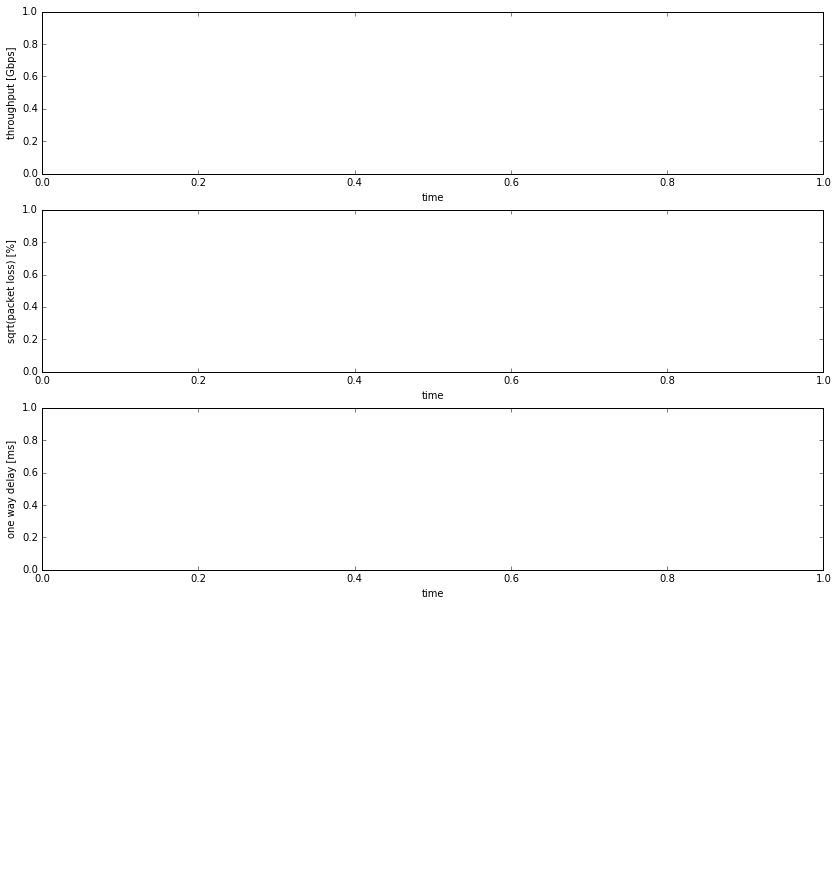

In [10]:


#plt.
figure(figsize=[14, 15])
gs = gridspec.GridSpec(4, 1, height_ratios=[2,2,2,3])

ax0 = plt.subplot(gs[0])
#ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
#ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
ax0.set_xlabel('time')
ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')
#plt.xlim(xmin=0)
ax0.legend()

ax2 = plt.subplot(gs[1])
#ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
#ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()


ax4 = plt.subplot(gs[2])
#ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
#ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax4.set_xlabel('time')
ax4.set_ylabel('one way delay [ms]')
ax4.legend()


ax5 = plt.subplot(gs[3])

plt.axis('off')
plt.savefig('Plots/UserReport_' + uName + '.png')
plt.show()